##Day 25 Lecture 1 Assignment
In this assignment, we will evaluate the performance of the model we built yesterday on the Chicago traffic crash data. We will also perform hyperparameter tuning and evaluate a final model using additional metrics (e.g. AUC-ROC, precision, recall, etc.)

Since we will be building on the model we built in the last assignment, we will need to redo all of the data preparation steps up to the point of model building. These steps include creating the response, missing value imputation, and one-hot encoding our selected categorical variables. The quickest way to get going would be to open last week's assignment, make a copy, and build on it from there.

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
def missingness_summary(df, print_log=False, sort='none'):
    summary = df.apply(lambda x: x.isna().sum() / x.shape[0])
    
    if print_log == True:
        if sort == 'none':
            print(summary)
        elif sort == 'ascending':
            print(summary.sort_values())
        elif sort == 'descending':
            print(summary.sort_values(ascending=False))
        else:
            print('Invalid value for sort parameter.')
        
    return summary

In [ ]:
crash_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/traffic_crashes_chicago.csv')

In [ ]:
crash_data.head()

,RD_NO,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,REPORT_TYPE,CRASH_TYPE,INTERSECTION_RELATED_I,NOT_RIGHT_OF_WAY_I,HIT_AND_RUN_I,DAMAGE,DATE_POLICE_NOTIFIED,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,STREET_NO,STREET_DIRECTION,STREET_NAME,BEAT_OF_OCCURRENCE,PHOTOS_TAKEN_I,STATEMENTS_TAKEN_I,DOORING_I,WORK_ZONE_I,WORK_ZONE_TYPE,WORKERS_PRESENT_I,NUM_UNITS,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN
0,JC334993,7/4/2019 22:33,45,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",REAR END,DIVIDED - W/MEDIAN BARRIER,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,NO INJURY / DRIVE AWAY,NaN,NaN,NaN,"OVER $1,500",7/4/2019 23:05,FOLLOWING TOO CLOSELY,NOT APPLICABLE,300,N,LAKE SHORE DR SB,114.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,JC370822,7/30/2019 10:22,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DIVIDED - W/MEDIAN (NOT RAISED),NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,NO INJURY / DRIVE AWAY,NaN,NaN,NaN,"OVER $1,500",7/30/2019 10:25,FAILING TO YIELD RIGHT-OF-WAY,IMPROPER TURNING/NO SIGNAL,8201,S,DR MARTIN LUTHER KING JR DR,631.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,JC387098,8/10/2019 17:00,25,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,ONE-WAY,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,NO INJURY / DRIVE AWAY,NaN,NaN,NaN,"$501 - $1,500",8/10/2019 17:35,EQUIPMENT - VEHICLE CONDITION,NOT APPLICABLE,6747,S,CREGIER AVE,332.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,JC395195,8/16/2019 16:53,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,NOT DIVIDED,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,NO INJURY / DRIVE AWAY,NaN,NaN,Y,"$501 - $1,500",8/16/2019 16:53,UNABLE TO DETERMINE,NOT APPLICABLE,554,N,FRANKLIN ST,1831.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,JC396604,8/17/2019 16:04,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,PARKING LOT,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,NO INJURY / DRIVE AWAY,NaN,NaN,Y,"$501 - $1,500",8/17/2019 18:30,UNABLE TO DETERMINE,UNABLE TO DETERMINE,3700,N,WESTERN AVE,1921.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,1.0,0.0


First, create a binary response column by modifying the "DAMAGE" column. Consider "OVER \$1500" to be the positive class, and under \$1500 to be the negative class.

In [ ]:
crash_data['DAMAGE_BIN'] = np.where(crash_data['DAMAGE'] == "OVER $1,500", 1, 0)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


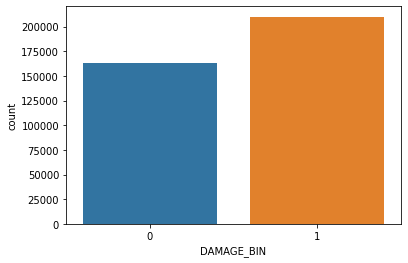

In [ ]:
sns.countplot(crash_data['DAMAGE_BIN'])

Using the code from Day 21, Lecture 1 as a starting point, devise an appropriate way to address missing values. You have a lot of freedom here; we will proceed by taking the following steps:

- Dropping all columns with more than 5% missing data
- Imputing the median for numeric columns with less than 5% missing data (except for STREET_NO; imputing it in this manner would not make any sense)
- Dropping rows with missing data for categorical columns that have less than 5% missing data

In [ ]:
crash_data.isnull().mean()

RD_NO                            0.000000
CRASH_DATE                       0.000000
POSTED_SPEED_LIMIT               0.000000
TRAFFIC_CONTROL_DEVICE           0.000000
DEVICE_CONDITION                 0.000000
WEATHER_CONDITION                0.000000
LIGHTING_CONDITION               0.000000
FIRST_CRASH_TYPE                 0.000000
TRAFFICWAY_TYPE                  0.000000
LANE_CNT                         0.467107
ALIGNMENT                        0.000000
ROADWAY_SURFACE_COND             0.000000
ROAD_DEFECT                      0.000000
REPORT_TYPE                      0.023012
CRASH_TYPE                       0.000000
INTERSECTION_RELATED_I           0.779457
NOT_RIGHT_OF_WAY_I               0.953917
HIT_AND_RUN_I                    0.722423
DAMAGE                           0.000000
DATE_POLICE_NOTIFIED             0.000000
PRIM_CONTRIBUTORY_CAUSE          0.000000
SEC_CONTRIBUTORY_CAUSE           0.000000
STREET_NO                        0.000000
STREET_DIRECTION                 0

In [ ]:
toDrop = crash_data.columns[crash_data.isnull().mean() > 0.05]
crash_data.drop(toDrop, axis=1, inplace=True)

In [ ]:
crash_data.drop('STREET_NO', axis=1, inplace=True)

In [ ]:
crash = crash_data.copy()

In [ ]:
crash.isnull().mean()

RD_NO                            0.000000
CRASH_DATE                       0.000000
POSTED_SPEED_LIMIT               0.000000
TRAFFIC_CONTROL_DEVICE           0.000000
DEVICE_CONDITION                 0.000000
WEATHER_CONDITION                0.000000
LIGHTING_CONDITION               0.000000
FIRST_CRASH_TYPE                 0.000000
TRAFFICWAY_TYPE                  0.000000
ALIGNMENT                        0.000000
ROADWAY_SURFACE_COND             0.000000
ROAD_DEFECT                      0.000000
REPORT_TYPE                      0.023012
CRASH_TYPE                       0.000000
DAMAGE                           0.000000
DATE_POLICE_NOTIFIED             0.000000
PRIM_CONTRIBUTORY_CAUSE          0.000000
SEC_CONTRIBUTORY_CAUSE           0.000000
STREET_DIRECTION                 0.000005
STREET_NAME                      0.000003
BEAT_OF_OCCURRENCE               0.000011
NUM_UNITS                        0.003755
MOST_SEVERE_INJURY               0.005795
INJURIES_TOTAL                   0

In [ ]:
toImpute = crash_data.columns[crash_data.isnull().mean() < 0.05]

In [ ]:
crash['RD_NO'].dtypes

dtype('O')

In [ ]:
for col in toImpute:
    if crash[col].dtypes != 'O': 
        crash[col].fillna(crash[col].mean(), inplace=True)

Finally, choose a few numeric and categorical features (2-3 of each) to include in the model. (You can definitely include more than this, but too many features, especially categorical ones, will most likely lead to convergence issues). One hot encode the chosen categorical features, being sure to omit one of the categories (which will serve as a "reference" level) to avoid perfect multicollinearity.

Again, you have a lot of freedom here; we will proceed with the following features, dropping the most commonly occurring category for the two categorical variables ("CLEAR" for weather, "REAR END" for first crash type):
POSTED_SPEED_LIMIT, WEATHER_CONDITION, INJURIES_TOTAL, FIRST_CRASH_TYPE

In [ ]:
crash_mod = pd.get_dummies(crash[['POSTED_SPEED_LIMIT', 'WEATHER_CONDITION', 'INJURIES_TOTAL', 'FIRST_CRASH_TYPE', 'DAMAGE_BIN']], drop_first=True)

In [ ]:
crash_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372585 entries, 0 to 372584
Data columns (total 30 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   POSTED_SPEED_LIMIT                             372585 non-null  int64  
 1   INJURIES_TOTAL                                 372585 non-null  float64
 2   DAMAGE_BIN                                     372585 non-null  int64  
 3   WEATHER_CONDITION_CLEAR                        372585 non-null  uint8  
 4   WEATHER_CONDITION_CLOUDY/OVERCAST              372585 non-null  uint8  
 5   WEATHER_CONDITION_FOG/SMOKE/HAZE               372585 non-null  uint8  
 6   WEATHER_CONDITION_FREEZING RAIN/DRIZZLE        372585 non-null  uint8  
 7   WEATHER_CONDITION_OTHER                        372585 non-null  uint8  
 8   WEATHER_CONDITION_RAIN                         372585 non-null  uint8  
 9   WEATHER_CONDITION_SEVERE CROSS WIND G

Split the data into train and test, with 80% training and 20% testing. By default, the LR output from statsmodels does not include an intercept terms; add a constant column to the training data so that an intercept term is calculated for the LR model (hint: sm.add_constant() is a useful function to accomplish this).

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = crash_mod.drop('DAMAGE_BIN', axis=1)
Y = crash_mod['DAMAGE_BIN']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

Fit the logistic regression model using the statsmodels package and print out the coefficient summary. Which variables (in particular, which categories of our categorical variables) appear to be the most important, and what effect do they have on the probability of a crash resulting in $1500 or more in damages?

In [ ]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(max_iter=1000)
logit.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
logit_params = pd.Series(logit.coef_.reshape(-1,), index=X_train.columns)
logit_params['intercept'] = logit.intercept_[0]

logit_params

POSTED_SPEED_LIMIT                               0.011792
INJURIES_TOTAL                                   0.733763
WEATHER_CONDITION_CLEAR                         -0.130323
WEATHER_CONDITION_CLOUDY/OVERCAST               -0.025746
WEATHER_CONDITION_FOG/SMOKE/HAZE                 0.003518
WEATHER_CONDITION_FREEZING RAIN/DRIZZLE          0.298747
WEATHER_CONDITION_OTHER                          0.037681
WEATHER_CONDITION_RAIN                           0.005945
WEATHER_CONDITION_SEVERE CROSS WIND GATE         0.180721
WEATHER_CONDITION_SLEET/HAIL                     0.026756
WEATHER_CONDITION_SNOW                          -0.015058
WEATHER_CONDITION_UNKNOWN                        0.034314
FIRST_CRASH_TYPE_ANIMAL                         -0.961199
FIRST_CRASH_TYPE_FIXED OBJECT                    0.064427
FIRST_CRASH_TYPE_HEAD ON                        -0.052389
FIRST_CRASH_TYPE_OTHER NONCOLLISION             -1.109436
FIRST_CRASH_TYPE_OTHER OBJECT                   -0.644812
FIRST_CRASH_TY

Create a LogisticRegression model with sklearn. Use the .predict() method (using X_test) to get a y_pred. Create a confusion matrix comparing your actual y_test to your prediction. What do you notice about your type of error?

In [ ]:
damage_prob = logit.predict_proba(X_test)

In [ ]:
damage_prob = pd.DataFrame(damage_prob, columns=['OVER $1,500', 'BELOW $1,500'])

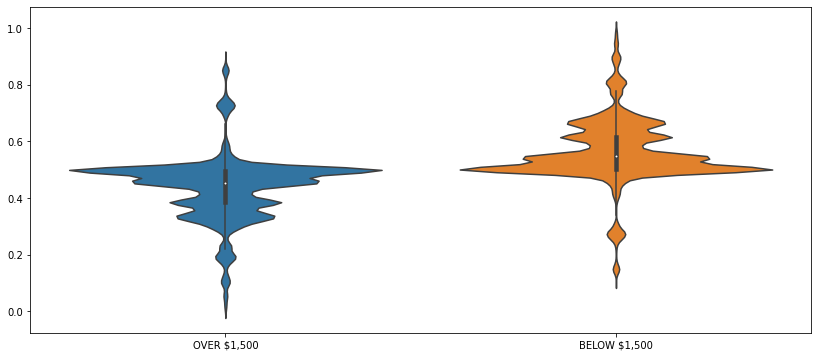

In [ ]:
plt.figure(figsize=(14,6))
sns.violinplot(data = damage_prob)
plt.show()

In [ ]:
y_pred = logit.predict(X_test)

In [ ]:
y_test

142501    0
52887     1
258811    1
369281    0
143607    1
         ..
65307     1
88681     1
207685    0
74588     1
51951     1
Name: DAMAGE_BIN, Length: 74517, dtype: int64

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
matrix = confusion_matrix(y_test, y_pred)
matrix

array([[ 9698, 22737],
       [ 8232, 33850]])

In [ ]:
accuracy = (matrix[0,0] + matrix[1,1])/((matrix[0,0] + matrix[0,1]) + (matrix[1,0] + matrix[1,1]))
print('Accuracy:')
print(accuracy)

Accuracy:
0.5844035589194412


In [ ]:
error = 1-accuracy
print('Error Rate:')
print(error)

Error Rate:
0.4155964410805588


In [ ]:
fp = (matrix[0,1])/(matrix[0,0] + matrix[0,1])
print('False Positive Rate:')
print(fp)

False Positive Rate:
0.701002004008016


In [ ]:
fn = (matrix[1,0])/(matrix[1,0] + matrix[1,1])
print('False Negative Rate:')
print(fn)

False Negative Rate:
0.19561807898864123


>*The model makes a lot of Type I errors with a ~70% probability of getting one. There is a ~19% probability for Type II errors, making it considerably lower than the accuracy which is at ~58%.*

Statsmodels' implementation of logistic has certain advantages over scikit-learn's, such as clean, easy to read model summary output and statistical inference values (e.g. p-values). However, scikit-learn is preferable for model evaluation, so we will switch to the scikit-learn implementation for this exercise. 

Run logistic regression on the training set and use the resulting model to make predictions on the test set. Calculate the train and test error using logarithmic loss. How do they compare to each other?

In [ ]:
from sklearn.metrics import log_loss
train_prob = logit.predict_proba(X_train)
test_prob = logit.predict_proba(X_test)

log_loss_test = log_loss(y_test, test_prob)
log_loss_train = log_loss(y_train, train_prob)
print("Train log loss: ", log_loss_train)
print("Test log loss: ",log_loss_test)


Train log loss:  0.657363529483762
Test log loss:  0.6574173571894316


Next, evaluate the performance of the same model using 10-fold CV. Use the training data and labels, and print out the mean log loss for each of the 10 CV folds, as well as the overall CV-estimated test error. How do the estimates from the individual folds compare to the result from our previous single holdout set? How much variability in the estimated test error do you see across the 10 folds?

Note: scikit-learn's cross_val_score function provides a simple, one-line method for doing this. However, be careful - the default score returned by this function may not be log loss!

In [ ]:
# answer goes here
from sklearn.model_selection import cross_val_score
cross_val = cross_val_score(logit, X_train, y_train, cv=10, scoring='neg_log_loss')
cross_val


array([-0.65788584, -0.6599658 , -0.65885973, -0.6562021 , -0.65553263,
       -0.65758626, -0.65546276, -0.65840746, -0.65752448, -0.65714005])

In [ ]:
abs(cross_val.mean())

0.6574567118632243

Scikit-learn's logistic regression function has a built-in regularization parameter, C (the larger the value of C, the smaller the degree of regularization). Use a loop with values of C, and find the optimum C value by taking the highest average cross validation score.

In [ ]:
cv_values = []
for x in [.01,.5,1.,100.,10000.]:
  logit = LogisticRegression(max_iter=1000, C=x)
  cross_val = cross_val_score(logit, X_train, y_train, cv=5)
  cv_values.append(cross_val.mean())

In [ ]:
cv_values

[0.5846753114943686,
 0.5849906750645757,
 0.5849336412567471,
 0.5849839655127064,
 0.5849369963984905]

Re-train a logistic regression model using the best value of C identified by 10-fold CV on the training data and labels. Afterwards, do the following:

Determine the precision, recall, and F1-score of our model using a cutoff/threshold of 0.5 (hint: scikit-learn's classification_report function may be helpful)
Plot or otherwise generate a confusion matrix
Plot the ROC curve for our logistic regression model
Note: the performance of our simple logistic regression model with just four features will not be very good, but this is not entirely unexpected. There are many other features that can be incorporated into the model to improve its performance; feel free to experiment!

In [ ]:
logit = LogisticRegression(max_iter=1000, C=10000)
logit.fit(X_train, y_train)

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.30      0.39     32435
           1       0.60      0.80      0.69     42082

    accuracy                           0.58     74517
   macro avg       0.57      0.55      0.54     74517
weighted avg       0.57      0.58      0.56     74517



In [ ]:
confusion_matrix(y_test, y_pred)

array([[ 9698, 22737],
       [ 8232, 33850]])

0.38498036092951227


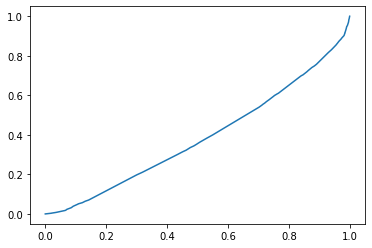

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_prob = logit.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,0])
line0, = plt.plot(fpr, tpr)
print(roc_auc_score(y_test,y_pred_prob[:,0]))